In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Do Androids Dream of Electric Sheep? Dick,8.005476,2.668492,5.468091,3
"Jane Eyre, Bronte",129.536641,16.192080,22.849644,8
Azure AD Authentication,473.590339,39.465862,108.463736,12
Email Auth and Security,481.937431,60.242179,141.048832,8
Logging in Python,507.711914,36.265137,77.072678,14
RAG Project,814.497914,81.449791,225.325674,10
Debugging in VS Code,961.980116,87.452738,216.946494,11
Azure Private DNS,1025.754007,53.987053,124.185792,19
C# Basics,1229.804108,39.671100,110.732323,31
Azure Functions + PP365,1479.548278,70.454680,196.055219,21


# Histogram

sum of ages: ~37050.08


<Axes: >

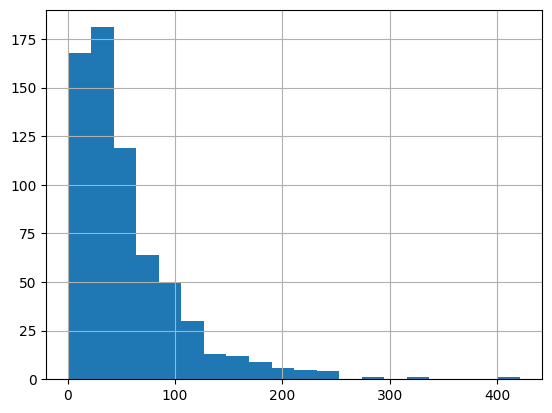

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~37050.08


<Axes: >

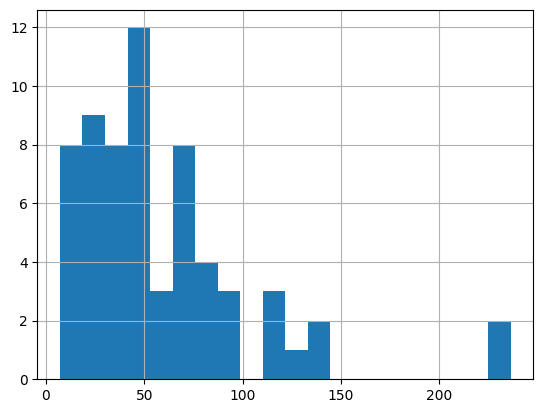

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [8]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [9]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [10]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [11]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [12]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [13]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 664
Total card age: 37050.08


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
98,Azure Developer Associate,Which two parameters are mandatory for ReadIte...,30b4e50f9b3e9f37a1f858991c1f2f26,-236.343967,59.338312,236.343967,-3738.313634,0.252007,0,0
101,Azure Developer Associate,"Front: In Autoscale, if you set maxThroughput ...",1abcbe1cc0bbc3da090bc2db9f15a62f,-135.513438,59.338312,236.343967,-3738.313634,0.252007,3,0
200,Azure Developer Associate,This item tests the candidate’s knowledge of d...,6e17d4c31473801bde009eebf868e33a,-118.935678,59.338312,236.343967,-3738.313634,0.252007,6,0
203,Azure Developer Associate,You need to delete an image with the tag dev/n...,5752b585aa824d5fdff241af9d695d49,-90.841458,59.338312,236.343967,-3738.313634,0.252007,9,0
284,Azure Developer Associate,Type of Azure Container Registry authenticatio...,2c6c4090c5baa34e50b0fcee05820253,-78.191143,59.338312,236.343967,-3738.313634,0.252007,12,0
355,Azure Developer Associate,What Azure CLI command allows CORS from https:...,95d2a75240a646635b69d89fe62896ef,-74.782792,59.338312,236.343967,-3738.313634,0.252007,15,0
356,Azure Developer Associate,How can you group keys in Azure App Configurat...,841cf130fcef72dbef5c554ba7e48011,-69.623113,59.338312,236.343967,-3738.313634,0.252007,18,0
422,Azure Developer Associate,Geo-replication enables a container registry t...,bc0e2da023ab89eb21878030f1e01e8a,-68.140029,59.338312,236.343967,-3738.313634,0.252007,21,0
424,Azure Developer Associate,Which role is required to generate a user dele...,4cd23bedbb8767d0fa5ef3af1af19dc8,-61.241320,59.338312,236.343967,-3738.313634,0.252007,24,0
479,Azure Developer Associate,You plan to create an Azure Functions app name...,b2f7e7ddaa88e9f0c115bd06cb95b214,-52.090211,59.338312,236.343967,-3738.313634,0.252007,27,0


## Age Mean

In [14]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [15]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [16]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [17]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [18]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
1,Do Androids Dream of Electric Sheep? Dick,Kipple (KIP-uhl): A term coined by author Phil...,087bf4b74ec5d79f84513edb5dad7fdc,-1.037529,2.668492,5.468091,-8.005476,0.668718,2,2
0,Do Androids Dream of Electric Sheep? Dick,"Caterwauled (KAT-er-wawld): Past tense of ""cat...",e0d5418fcba056043cbe9db9b68ebc68,-1.499856,2.668492,5.468091,-8.005476,0.668718,1,1
209,Debugging in VS Code,Watchpoint\nA debugging feature that pauses ex...,7220771e05c8839276baa18cb1797fb2,-4.627819,87.452738,216.946494,-961.980116,0.133217,10,1
2,Do Androids Dream of Electric Sheep? Dick,"Cogitated (KOJ-i-teyt-ed): Past tense of ""cogi...",43b7b6ed69e2071e68043d97b76820b2,-5.468091,2.668492,5.468091,-8.005476,0.668718,0,0
488,Python,Q:\nHow do you retrieve the next value from a ...,a787235de4d115775cc87fe026bf9266,-6.181985,77.362562,250.225436,-2475.601989,0.103382,31,1
487,Python,Q:\nWhat is the default exit code if a Python ...,b1c1e2234bc8df974f6b207465761b32,-6.417325,77.362562,250.225436,-2475.601989,0.103382,30,0
662,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,-6.621914,37.079981,162.697074,-3188.878399,0.221976,85,1
112,Email Auth and Security,MUA (Mail User Agent)\n\nAn email client used ...,728b4872797d6311a0966fa924d6341d,-6.626953,60.242179,141.048832,-481.937431,0.114867,7,1
661,Vocab,"How to Sell a Haunted House, Hendrix\nCodicil\...",1de7e737fadc28eb277f75c71abda291,-6.655774,37.079981,162.697074,-3188.878399,0.221976,84,0
637,Azure Developer Associate,What default retention period does Azure Monit...,f7db982de5cba0aac0d231441791266d,-7.116109,59.338312,236.343967,-3738.313634,0.252007,62,2


In [19]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   Which two parameters are mandatory for ReadIte...
hash                   30b4e50f9b3e9f37a1f858991c1f2f261abcbe1cc0bbc3...
age                                                           -985.70315
subject_mean_age                                              593.383117
subject_highest_age                                          2363.439668
subject_age_sum                                            -37383.136345
head_random_roll                                                2.520072
count                                                                135
n_fold                                                                 0
dtype: object

In [20]:
existing_cards['age'].mean()

-55.798309255513516